In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def create_mnist_data(num_classes, task_index,csv_file="mnist.csv", image_shape=(1, 28, 28)):
    mnist_file = open(csv_file)
    df = pd.read_csv(mnist_file)

    all_classes = sorted(df['label'].unique())
    start_class = task_index * num_classes
    end_class = start_class + num_classes
    valid_classes = all_classes[start_class:end_class]


    filtered_df = df[df['label'].isin(valid_classes)]


    X = filtered_df.drop(columns=['label']).values
    y = filtered_df['label'].values


    X = torch.tensor(X / 255.0, dtype=torch.float32)
    X = X.view(-1, *image_shape)
    y = torch.tensor(y, dtype=torch.long)

    return TensorDataset(X, y)

In [3]:
def inference_on_model(model, loader, num_classes):

    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(loader):
            images, labels = images.to(device), labels.to(device)


            if len(images.shape) == 3:
                images = images.unsqueeze(1)

            logits = model(images)
            predictions = torch.argmax(logits, dim=1)

            all_preds.extend(predictions.cpu().numpy())

            if labels.ndimension() == 0:
                labels = labels.unsqueeze(0)

            all_labels.extend(labels.cpu().numpy())

            if batch_idx % 2000 == 0:
                print(f"Batch {batch_idx} Predictions:")
                print(f"Predicted: {predictions.cpu().numpy()}")
                print(f"True:      {labels.cpu().numpy()}")

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")

    cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(range(num_classes)),
                yticklabels=list(range(num_classes)))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def train_model(model, data_loader, criterion, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)


In [6]:
def evaluate_model(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total


In [7]:
num_classes_per_task = [5, 5]
image_shape = (1, 28, 28)

task1_data = create_mnist_data(num_classes_per_task[0], task_index=0, image_shape=image_shape)
task2_data = create_mnist_data(num_classes_per_task[1], task_index=1, image_shape=image_shape)
data = create_mnist_data(10, task_index=0, image_shape=image_shape)

task_data = [(task1_data, task1_data), (task2_data, task2_data)]

batch_size = 64
task1_loader = DataLoader(task1_data, batch_size=batch_size, shuffle=True)
task2_loader = DataLoader(task2_data, batch_size=batch_size, shuffle=True)
combined_data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Finetuning Approach

In [8]:
num_classes = 10
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train on task 1
print("Training on Task 1...")
train_model(model, task1_loader, criterion, optimizer, epochs=5, device=device)
accuracy_task1 = evaluate_model(model, task1_loader, device)
print(f"Accuracy on Task 1: {accuracy_task1:.2f}")

# Fine-tune on task 2 with reduced learning rate
print("Fine-tuning on Task 2...")
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.00001  # Reduce learning rate

train_model(model, task2_loader, criterion, optimizer, epochs=5, device=device)
accuracy_task2 = evaluate_model(model, task2_loader, device)
print(f"Accuracy on Task 2: {accuracy_task2:.2f}")

# Final evaluation on all classes
accuracy_combined = evaluate_model(model, combined_data_loader, device)
print(f"Final Accuracy on All Classes: {accuracy_combined:.2f}")


Training on Task 1...


Epoch 5/5: 100%|██████████| 335/335 [00:01<00:00, 187.43batch/s, loss=0.011]


Accuracy on Task 1: 1.00
Fine-tuning on Task 2...


Epoch 5/5: 100%|██████████| 322/322 [00:01<00:00, 182.34batch/s, loss=0.898]


Accuracy on Task 2: 0.83
Final Accuracy on All Classes: 0.75


Batch 0 Predictions:
Predicted: [1 5 1 4 5 0 7 3 5 5 8 7 1 3 5 1 2 5 7 5 8 6 2 5 2 3 6 7 7 7 8 9 4 7 2 1 3
 1 1 4 8 1 4 9 2 6 3 7 7 4 7 5 1 9 5 2 2 3 7 1 1 8 5 5]
True:      [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 4 2 6 3 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0]

Accuracy: 74.98%


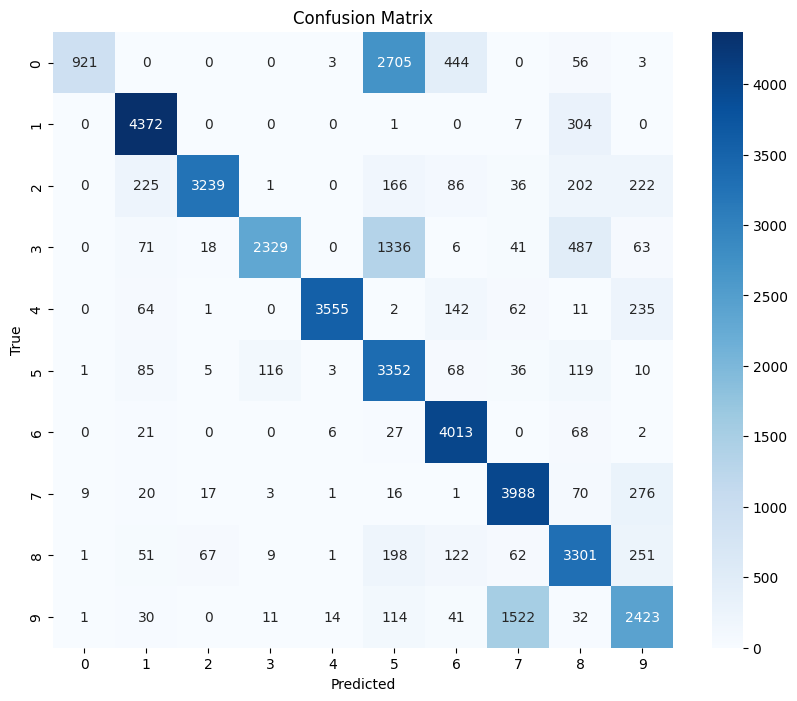

[[ 921    0    0    0    3 2705  444    0   56    3]
 [   0 4372    0    0    0    1    0    7  304    0]
 [   0  225 3239    1    0  166   86   36  202  222]
 [   0   71   18 2329    0 1336    6   41  487   63]
 [   0   64    1    0 3555    2  142   62   11  235]
 [   1   85    5  116    3 3352   68   36  119   10]
 [   0   21    0    0    6   27 4013    0   68    2]
 [   9   20   17    3    1   16    1 3988   70  276]
 [   1   51   67    9    1  198  122   62 3301  251]
 [   1   30    0   11   14  114   41 1522   32 2423]]


In [9]:
inference_on_model(model,combined_data_loader,10)

# Knowledge Distillation

In [10]:
def train_model_with_kd(student, teacher, data_loader, optimizer, criterion_ce, criterion_kd, alpha, temperature, epochs, device):
    student.train()
    teacher.eval()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()

                student_outputs = student(X_batch)

                with torch.no_grad():
                    teacher_outputs = teacher(X_batch)

                kd_loss = criterion_kd(
                    nn.functional.log_softmax(student_outputs / temperature, dim=1),
                    nn.functional.softmax(teacher_outputs / temperature, dim=1)
                ) * (temperature ** 2)

                ce_loss = criterion_ce(student_outputs, y_batch)

                loss = alpha * kd_loss + (1 - alpha) * (ce_loss * 2)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)

In [13]:
teacher_model = SimpleCNN(num_classes=num_classes).to(device)
student_model = SimpleCNN(num_classes=num_classes).to(device)

criterion_ce = nn.CrossEntropyLoss()
criterion_kd = nn.KLDivLoss(reduction='batchmean')
optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.0005)

# Train teacher on Task 1
print("Training Teacher Model on Task 1...")
train_model(teacher_model, task1_loader, criterion_ce, optimizer_teacher, epochs=5, device=device)
accuracy_task1 = evaluate_model(teacher_model, task1_loader, device)
print(f"Teacher Model Accuracy on Task 1: {accuracy_task1:.2f}")

# Fine-tune student on Task 2 with KD
print("Fine-tuning Student Model on Task 2 using KD...")
alpha = 0.5
temperature = 1.0
train_model_with_kd(
    student=student_model,
    teacher=teacher_model,
    data_loader=task2_loader,
    optimizer=optimizer_student,
    criterion_ce=criterion_ce,
    criterion_kd=criterion_kd,
    alpha=alpha,
    temperature=temperature,
    epochs=5,
    device=device
)

# Evaluate student on all classes
accuracy_combined = evaluate_model(student_model, combined_data_loader, device)
print(f"Student Model Final Accuracy on All Classes: {accuracy_combined:.2f}")


Training Teacher Model on Task 1...


Epoch 5/5: 100%|██████████| 335/335 [00:01<00:00, 183.00batch/s, loss=0.0098]


Teacher Model Accuracy on Task 1: 1.00
Fine-tuning Student Model on Task 2 using KD...


Epoch 5/5: 100%|██████████| 322/322 [00:01<00:00, 165.75batch/s, loss=1.05]


Student Model Final Accuracy on All Classes: 0.88


Batch 0 Predictions:
Predicted: [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 5 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 9 7 6 3 7 7 4 7 5 1 9 6 7 2 3 9 1 1 1 5 6]
True:      [1 0 1 4 0 0 7 3 5 3 8 9 1 3 3 1 2 0 7 5 8 6 2 0 2 3 6 9 9 7 8 9 4 9 2 1 3
 1 1 4 9 1 4 4 2 6 3 7 7 4 7 5 1 9 0 2 2 3 9 1 1 1 5 0]

Accuracy: 87.75%


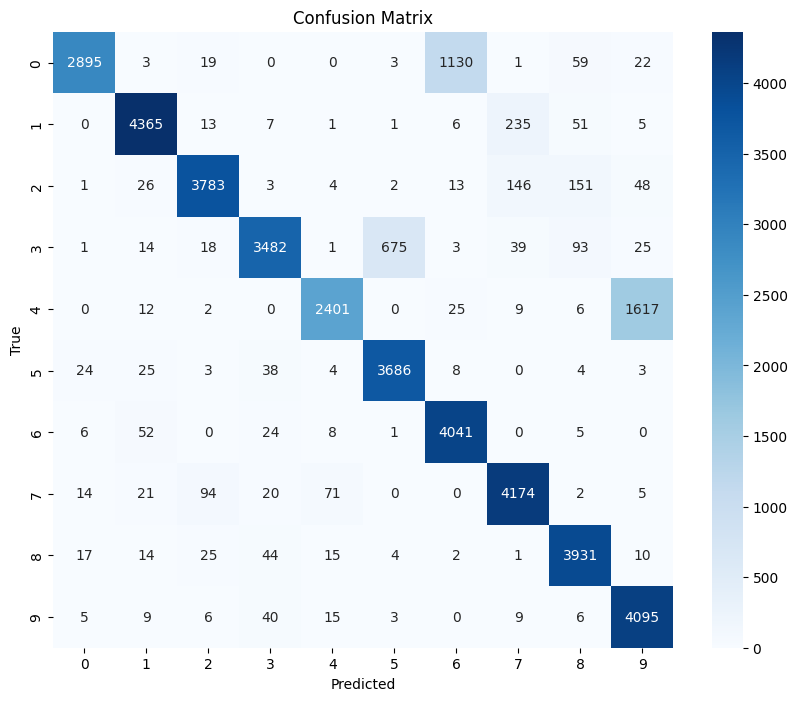

[[2895    3   19    0    0    3 1130    1   59   22]
 [   0 4365   13    7    1    1    6  235   51    5]
 [   1   26 3783    3    4    2   13  146  151   48]
 [   1   14   18 3482    1  675    3   39   93   25]
 [   0   12    2    0 2401    0   25    9    6 1617]
 [  24   25    3   38    4 3686    8    0    4    3]
 [   6   52    0   24    8    1 4041    0    5    0]
 [  14   21   94   20   71    0    0 4174    2    5]
 [  17   14   25   44   15    4    2    1 3931   10]
 [   5    9    6   40   15    3    0    9    6 4095]]


In [14]:
inference_on_model(student_model,combined_data_loader,10)